In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Layer, concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf

plt.rc('font', size=20)
plt.rcParams["font.family"] = "serif"

In [23]:
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

RuntimeError: Physical devices cannot be modified after being initialized

In [25]:
N_samples = 10**5
distortion = 5
n_moments = 5

learning_rate = 1e-5
n_epochs = 100
batch_size = 128*10


x_truth = np.random.normal(-0.5,1, N_samples) #particle level data
x_data = np.random.normal(x_truth, distortion) #detector level data

x_gen = np.random.normal(0,1,N_samples) #particle level simulation
x_sim = np.random.normal(x_gen, distortion) #detector level simulation

In [26]:
initializer = tf.keras.initializers.RandomUniform(minval=-5., maxval=5.)

class MyLayer(Layer):

    def __init__(self, myc, **kwargs):
        self.myinit = myc
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self._lambda = self.add_weight(name='lambda', 
                                    shape=(n_moments,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return tf.exp(sum([self._lambda[i]* x**(i+1) for i in range(n_moments)]))

In [27]:
def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss

    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred)/weights_1 +
                         (1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

def weighted_binary_crossentropy_GAN(y_true, y_pred):
    weights = tf.gather(y_pred, [1], axis=1) # event weights
    y_pred = tf.gather(y_pred, [0], axis=1) # actual y_pred for loss

    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)

    #tf.print("weights",weights_0,weights_1)

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = weights * ((1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

In [28]:
xvals_1 = np.concatenate([x_gen,x_truth])
yvals_1 = np.concatenate([np.ones(len(x_gen)),np.zeros(len(x_truth))])

xvals_2 = np.concatenate([x_sim,x_data])
yvals_2 = np.concatenate([np.ones(len(x_sim)),np.zeros(len(x_data))])

X_train_1, X_test_1, Y_train_1, Y_test_1, X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(xvals_1, 
                                                                                    yvals_1, xvals_2, yvals_2)
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
myc = 0.1

mymodel_inputtest = Input(shape=(1,))
    
mymodel_test = MyLayer(myc)(mymodel_inputtest)
model_generator = Model(mymodel_inputtest, mymodel_test)

inputs_disc = Input((1, ))
hidden_layer_1_disc = Dense(50, activation='relu')(inputs_disc)
hidden_layer_2_disc = Dense(50, activation='relu')(hidden_layer_1_disc)
hidden_layer_3_disc = Dense(50, activation='relu')(hidden_layer_2_disc)
outputs_disc = Dense(1, activation='sigmoid')(hidden_layer_3_disc)
model_discrimantor = Model(inputs=inputs_disc, outputs=outputs_disc)

model_discrimantor.compile(loss=weighted_binary_crossentropy, optimizer=opt)

model_discrimantor.trainable = False
mymodel_gan = Input(shape=(1,))
gan_model = Model(inputs=mymodel_gan,outputs=concatenate([model_discrimantor(mymodel_gan),model_generator(mymodel_gan)]))


gan_model.compile(loss=weighted_binary_crossentropy_GAN, optimizer=opt)

In [29]:
n_batches = len(X_train_1) // batch_size

for i in range(n_epochs):
    for j in range(n_batches):
        X_batch = X_train_2[j*batch_size:(j+1)*batch_size]
        Y_batch = Y_train_2[j*batch_size:(j+1)*batch_size]
        W_batch = model_generator(X_batch)
        W_batch = np.array(W_batch).flatten()
        W_batch[Y_batch==1] = 1

        Y_batch_2 = np.stack((Y_batch, W_batch), axis=1)

        model_discrimantor.train_on_batch(X_batch, Y_batch_2)

        gan_model.train_on_batch(X_batch[Y_batch==0],np.zeros(len(X_batch[Y_batch==0])))

    mylambda = np.array(model_generator.layers[-1].get_weights())
    if i%10 == 0:
        print("on epoch=",i, mylambda)

on epoch= 0 [[nan nan nan nan nan]]


KeyboardInterrupt: 

In [8]:
arr = np.array([mylambda[:, k]*x_truth**(k+1) for k in range(n_moments)])
exponent = np.exp(np.sum(arr, axis=0))
weights_1 = np.concatenate([np.ones(len(x_gen)),exponent*len(x_gen)/np.sum(exponent)])

X_train_1, X_test_1, Y_train_1, Y_test_1, X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_1, w_test_1 = train_test_split(xvals_1, 
                                                                                yvals_1, xvals_2, yvals_2, weights_1)

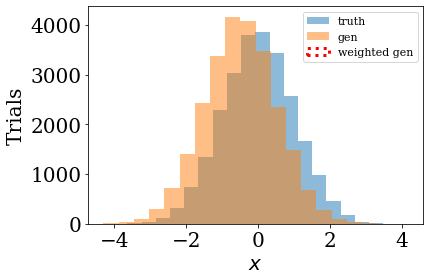

In [9]:

bins = 20
truth = X_test_1[Y_test_1==1]
gen = X_test_1[Y_test_1==0]
weights= w_test_1[Y_test_1==0]

_,_,_=plt.hist(truth,alpha=0.5,label="truth", bins=bins)
_,_,_=plt.hist(gen,alpha=0.5,label="gen", bins=bins)
_,_,_=plt.hist(gen,weights=weights,histtype="step",color="r",ls=":", lw=3,label="weighted gen", bins=bins)
plt.legend(fontsize=11)
plt.xlabel(r"$x$")
plt.ylabel("Trials")
plt.savefig("gaussexample.pdf", bbox_inches='tight', transparent=True)

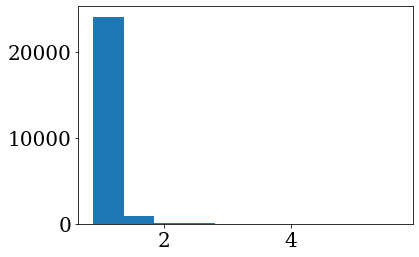

In [72]:
plt.hist(weights)
plt.show()

In [28]:
gauss_data = np.random.normal(0,1,100000)
gauss_sim = np.random.normal(-0.5,1,100000)

def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))
    return K.mean(t_loss)


losses = []
for lambda1 in np.linspace(-1,1,20):

    xvals_1 = np.concatenate([gauss_data,gauss_sim])
    yvals_1 = np.concatenate([np.ones(len(gauss_data)),np.zeros(len(gauss_sim))])
    weights_1 = np.concatenate([np.ones(len(gauss_data)),np.exp(lambda1*gauss_sim)*len(gauss_data)/np.sum(np.exp(lambda1*gauss_sim))])

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

    Y_train_2 = np.stack((Y_train_1, w_train_1), axis=1)
    Y_test_2 = np.stack((Y_test_1, w_test_1), axis=1)

    inputs = Input((1, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(loss=weighted_binary_crossentropy, optimizer='Adam', metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_2,
              epochs=10,
              batch_size=1000,
              verbose=0)
    losses+=[model.history.history['loss'][-1]]

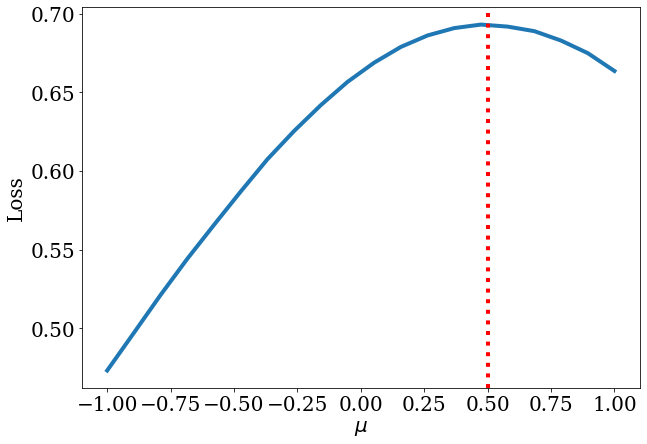

In [29]:
fig, ax = plt.subplots(figsize=(10, 7))

# ax.xaxis.label.set_color('white')        #setting up X-axis label color to yellow
# ax.yaxis.label.set_color('white')          #setting up Y-axis label color to blue

# ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
# ax.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to black

# ax.spines['left'].set_color('white')        # setting up Y-axis tick color to red
# ax.spines['top'].set_color('white')
# ax.spines['right'].set_color('white') 
# ax.spines['bottom'].set_color('white') 
plt.plot(np.linspace(-1,1,20),losses, lw=4)
plt.axvline(1/2, color="r",ls=":", lw=4)
plt.ylabel("Loss")
plt.xlabel(r"$\mu$")
plt.savefig("gaussloss.pdf", bbox_inches='tight',  transparent=True)

plt.show()

In [61]:
np.savez('2_level_gaussian.npz', losses=losses, truth=truth, gen=gen, weights=weights)

In [64]:
#run this cell directly to load data
npzfile = np.load('2_level_gaussian.npz')
losses=npzfile['losses']
truth=npzfile['truth']
gen=npzfile['gen']
weights=npzfile['weights']

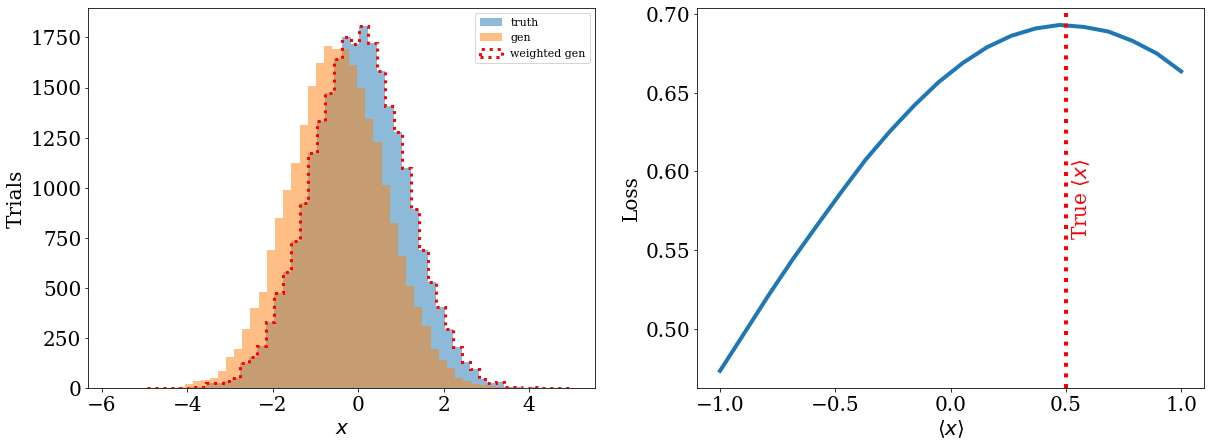

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

bins = 50
_,_,_=ax[0].hist(truth,alpha=0.5,label="truth", bins=bins)
_,_,_=ax[0].hist(gen,alpha=0.5,label="gen", bins=bins)
_,_,_=ax[0].hist(truth,weights=weights,histtype="step",color="r",ls=":", lw=3,label="weighted gen", bins=bins)
ax[0].legend(fontsize=11)
ax[0].set_xlabel(r"$x$")
ax[0].set_ylabel("Trials")

ax[1].plot(np.linspace(-1,1,20),losses, lw=4)
ax[1].axvline(1/2, color="r",ls=":", lw=4)
ax[1].set_ylabel("Loss")
ax[1].set_xlabel(r"$\langle x \rangle$")
ax[1].text(0.52,0.56,r'True $\langle x\rangle$',rotation=90, color='r')




plt.savefig("2_gauss_combined.pdf", bbox_inches='tight', transparent=True)